<a href="https://colab.research.google.com/github/dht7166/related_faces/blob/master/kaggle_faces_similar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x
import pandas as pd
import keras
from keras import layers
from keras import models
from keras.models import Model
import numpy as np
from keras import backend as K
from keras.activations import relu
from keras.layers import Input,Conv2D,LeakyReLU,BatchNormalization,MaxPool2D,Dense
from keras.layers import UpSampling2D,Add,Concatenate,Average, ReLU, Flatten

from keras.utils import Sequence
import random
import numpy as np
import glob
from skimage import io
from skimage import transform
from matplotlib import pyplot as plt
import os

Using TensorFlow backend.


In [0]:
workdir = 'drive/My Drive/kaggle_faces/'


## OUR IDEA
Our idea is to train an autoencoder.
At the output of the encoder, we concat/average the output of two seperate images, and use another deep convolutional on top of that to get the final verdict.

In [4]:
# Describe the autoencoder
encoder_in = Input((224,224,3))

# 3 layers of conv and max-pooling
x = Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',name = 'conv1')(encoder_in)
x = MaxPool2D(pool_size=(2,2))(x)
x = BatchNormalization()(x) 

x = Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',name = 'conv2')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',name = 'conv3')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = BatchNormalization()(x) 

encoder_out = Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',name = 'conv4')(x)
encoder_out = MaxPool2D(pool_size=(2,2))(encoder_out)

encoder = Model(encoder_in,encoder_out)
encoder.summary()













Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2 (Conv2D)               (None, 112, 112, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)

In [5]:
# Define the decoder part
decoder_in = Input((14,14,64))

# 3 layers of conv and max-pooling
x = UpSampling2D((2,2))(decoder_in)
x = Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',name = 'conv5')(x)
x = BatchNormalization()(x) 

x = UpSampling2D((2,2))(x)
x = Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',name = 'conv6')(x)
x = BatchNormalization()(x) 

x = UpSampling2D((2,2))(x)
x = Conv2D(filters=32,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',name = 'conv7')(x)
x = BatchNormalization()(x) 

decoder_out = UpSampling2D((2,2))(x)
decoder_out = Conv2D(filters=3,kernel_size=(5,5),strides=(1,1),padding='same',activation='sigmoid',name = 'conv8')(decoder_out)


decoder = Model(decoder_in,decoder_out)
decoder.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv5 (Conv2D)               (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv6 (Conv2D)               (None, 56, 56, 32)        51232     
_________________________________________________________________
batch_normalization_5 (Batch (None, 56, 56, 32)        128

In [6]:
# Finally, combine everything together to create the autoencoder
output = decoder(encoder.output)
autoencoder = Model(encoder.input,output)
opt = keras.optimizers.Adam(lr = 1e-3)
autoencoder.compile(optimizer=opt,loss = 'mse',)
autoencoder.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2 (Conv2D)               (None, 112, 112, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)        128

## Prepare the input
We will use keras generator for this task

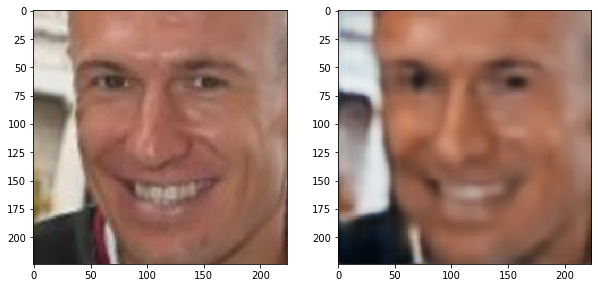

In [9]:
class TrainGenerator(Sequence):
  def __init__(self,workdir,batch = 10,model = None):
    self.images = []
    with open(workdir+'/list_images.csv') as f:
      for line in f:
        self.images.append((workdir + '/' + line).rstrip())
    
    self.batch = batch
    self.model = model
    

  def __len__(self):
    return int(len(self.images)/self.batch)

  def __getitem__(self,idx):
    X = np.zeros((self.batch,224,224,3))
    Y = np.zeros((self.batch,224,224,3))
    # Get the image 
    for i in range(self.batch*idx,(idx+1)*self.batch):
      # Get image i and put it into X and Y
      X[i-self.batch*idx] = io.imread(self.images[i])/255
      Y[i-self.batch*idx] = io.imread(self.images[i])/255
    return X,Y

  def on_epoch_end(self):
    random.shuffle(self.images)
    fig = plt.figure(figsize = (10,10))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.1)
    # Get one random image and display it
    image = io.imread(self.images[0])
    image = image[np.newaxis,:]/255
    fig.add_subplot(1,2,1)
    plt.imshow(image[0])
    image = self.model.predict(image)
    fig.add_subplot(1,2,2)
    plt.imshow(image[0])
    plt.show()

generator = TrainGenerator(workdir,batch = 20,model = autoencoder)
generator.on_epoch_end()

In [0]:
autoencoder.load_weights(workdir + '/best_loss.h5')

## Do the training
This is not a big model, so I think we can do a few epochs



In [0]:
ckpt_loss = keras.callbacks.ModelCheckpoint(workdir+'/best_loss.h5',monitor='loss',save_best_only=True)
autoencoder.fit_generator(generator=generator, epochs=3,steps_per_epoch=100, callbacks=[ckpt_loss]) # it tooks about 2 hours, which I dont have time so yeah less step per epoch
autoencoder.save_weights(workdir + '/autoencoder.h5')

Epoch 1/3
100/100 [==============================] - 910s 9s/step - loss: 0.0036
Epoch 2/3
 48/100 [=============>................] - ETA: 6:36 - loss: 0.0034

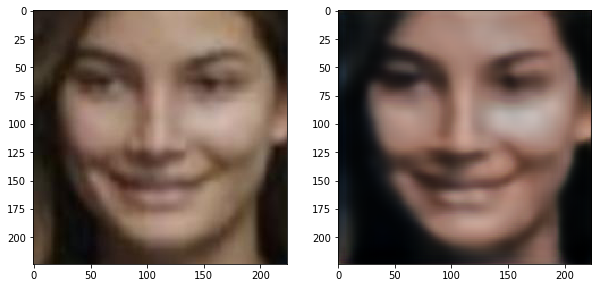

In [11]:
generator.on_epoch_end()

## The last bit
Now we come to the part where we can define a model that takes two input (the output of encoder), do something wiht it to get a binary output.

We do the training for images define in the relationship files. We also include people from different families to make sure they are not related, and assign label 0


In [75]:
# Freeze the encoder
encoder.trainable = False

combine_in_1 = Input((224,224,3))
combine_in_2 = Input((224,224,3))
combine_out_1 = encoder(combine_in_1)
combine_out_2 = encoder(combine_in_2)

# The average layer
x = Concatenate()([combine_out_1,combine_out_2])
x = Conv2D(32,kernel_size=(3,3),padding = 'same',activation='relu',strides=(1,1),name = 'conv5')(x)
x = MaxPool2D((2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(16,kernel_size=(3,3),padding = 'same',activation='relu',strides=(1,1),name = 'conv6')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(250,activation='relu',name = 'dense1')(x)
x = Dense(1,activation = 'sigmoid',name = 'combine_out')(x)


combine = Model([combine_in_1,combine_in_2],x)
combine_optimizer = keras.optimizers.Adam(lr = 1e-3)
combine.compile(optimizer=combine_optimizer,loss = 'binary_crossentropy',metrics = ['accuracy'])
combine.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 14, 14, 64)   182304      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 14, 14, 128)  0           model_1[11][0]             

In [0]:
# Define the training generator

import glob
import os
import random
import numpy as np
from skimage import io

class CombineGenerator(Sequence):
  def __init__(self,workdir,batch = 10):
    self.images = {}
    with open(workdir+'/list_train.csv') as f:
      for line in f:
        directory,_ = os.path.split(line.rstrip())
        image = workdir  + line.rstrip()
        if directory in self.images:
          self.images[directory].append(image)
        else:
          self.images[directory] = [image]
    
    self.db = pd.read_csv(workdir + '/train_relationships.csv')
    drop_row = []
    for i in range(len(self.db.index)):
      if ( ('train/'+self.db['p1'][i]) not in self.images) or (('train/'+self.db['p2'][i]) not in self.images):
        drop_row.append(i)
    self.db.drop(drop_row,inplace = True)
    self.db.reset_index(drop=True, inplace=True)
    self.batch = batch
    self.families = list(self.images.keys())

  def __len__(self):
    return int(len(self.db.index)/self.batch)    

  def on_epoch_end(self):
    self.db = self.db.sample(frac = 1).reset_index(drop = True)

  def __getitem__(self,idx):
    X1 = np.zeros((self.batch,224,224,3))
    X2 = np.zeros((self.batch,224,224,3))
    Y = np.zeros((self.batch,1))
    for i in range(self.batch*idx, self.batch * (idx+1)):
      if i%2:
        # while ( ('train/'+p1) not in self.images) or (('train/'+p2) not in self.images):
        #   off = random.randint(0,len(self.db.index)-1)
        p1 = self.db['p1'][i]
        p2 = self.db['p2'][i]
        img1 = random.choice(self.images['train/'+p1])
        img2 = random.choice(self.images['train/'+p2])
        Y[i-self.batch*idx] = 1
        # Read the two images, and put them through the encoder  
        img1 = io.imread(img1)/255
        img2 = io.imread(img2)/255
        X1[i-self.batch*idx] = img1
        X2[i-self.batch*idx] = img2
      else:
        p1 = random.choice(self.families)
        p2 = p1
        while p2 == p1:
          p2 = random.choice(self.families)
        img1 = random.choice(self.images[p1])
        img2 = random.choice(self.images[p2])
        Y[i-self.batch*idx] = 0
        # Read the two images, and put them through the encoder  
        img1 = io.imread(img1)/255
        img2 = io.imread(img2)/255
        X1[i-self.batch*idx] = img1
        X2[i-self.batch*idx] = img2
    

    return [X1,X2],Y



combine_generator =  CombineGenerator(workdir,batch = 20)


In [77]:
# Train the model on this new dataset

combine_checkpoint = keras.callbacks.ModelCheckpoint(workdir+ "/combine_best_loss.h5",monitor = 'loss',save_best_only=True)
combine_accuracy = keras.callbacks.ModelCheckpoint(workdir+ "/combine_best_accuracy.h5",monitor = 'accuracy',save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(monitor = 'loss',patience = 2)

# for i in range(100):
#   print("At step "+ str(i))
#   [X1,X2],Y = combine_generator.__getitem__(i)
#   print("Done getting data")
#   combine.fit([X1,X2],Y,epochs = 1,batch_size = 50)
#   if i%20 == 1 or i == 100 - 1:
#     combine.save_weights(workdir + '/combine.h5')
combine.fit_generator(combine_generator,epochs = 30, steps_per_epoch=20, callbacks = [combine_checkpoint,combine_accuracy,early_stop],verbose = 1)

Epoch 1/30
20/20 [==============================] - 85s 4s/step - loss: 0.9245 - acc: 0.4400


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/30
20/20 [==============================] - 68s 3s/step - loss: 0.8581 - acc: 0.4550
Epoch 3/30
20/20 [==============================] - 69s 3s/step - loss: 0.7652 - acc: 0.5125
Epoch 4/30
20/20 [==============================] - 52s 3s/step - loss: 0.7555 - acc: 0.5750
Epoch 5/30
20/20 [==============================] - 62s 3s/step - loss: 0.7481 - acc: 0.5075
Epoch 6/30
20/20 [==============================] - 56s 3s/step - loss: 0.6610 - acc: 0.6150
Epoch 7/30
20/20 [==============================] - 58s 3s/step - loss: 0.7293 - acc: 0.5450
Epoch 8/30
20/20 [==============================] - 50s 2s/step - loss: 0.6882 - acc: 0.5775


In [78]:
[X1,X2],Y =combine_generator.__getitem__(0)
combine.evaluate([X1,X2],Y,batch_size = 100)

20/20 [==============================] - 0s 24ms/step


[1.2710556983947754, 0.4000000059604645]

In [79]:
[X1,X2],Y =combine_generator.__getitem__(1)
combine.evaluate([X1,X2],Y,batch_size = 100)

20/20 [==============================] - 0s 2ms/step


[0.9102531671524048, 0.699999988079071]

In [90]:
p1 = random.choice(combine_generator.families)
p2 = p1
while p2 == p1:
  p2 = random.choice(combine_generator.families)
img1 = random.choice(combine_generator.images[p1])
img2 = random.choice(combine_generator.images[p2])
img1 = io.imread(img1)/255
img2 = io.imread(img2)/255
X1 = img1
X2 = img2
X1 = X1[np.newaxis,:]
X2 = X2[np.newaxis,:]
combine.predict([X1,X2])

array([[0.48132488]], dtype=float32)

In [83]:
i = random.randint(0,len(combine_generator.db.index)-1)
p1 = combine_generator.db['p1'][i]
p2 = combine_generator.db['p2'][i]
img1 = random.choice(combine_generator.images['train/'+p1])
img2 = random.choice(combine_generator.images['train/'+p2])
 
img1 = io.imread(img1)/255
img2 = io.imread(img2)/255
X1 = img1
X2 = img2
X1 = X1[np.newaxis,:]
X2 = X2[np.newaxis,:]
combine.predict([X1,X2])

array([[0.615591]], dtype=float32)